----
Dataset : Amazon Reviews Dataset
---
Sumber : Kaggle
----

In [70]:
!pip install -q kaggle

In [71]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shopinurhidayanti","key":"c75460582a7dbf7fe151b76fd79c51fd"}'}

In [72]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [73]:
!kaggle datasets download -d hgultekin/bbcnewsarchive

bbcnewsarchive.zip: Skipping, found more recently modified local copy (use --force to force download)


In [74]:
!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchive

mkdir: cannot create directory ‘bbcnewsarchive’: File exists
Archive:  bbcnewsarchive.zip
replace bbcnewsarchive/bbc-news-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: bbc-news-data.csv


In [75]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import re,string,unicodedata
from string import punctuation
from bs4 import BeautifulSoup

In [76]:
data = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')
data.head(100)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
95,business,096.txt,Burren awarded Egyptian contracts,British energy firm Burren Energy has been aw...
96,business,097.txt,'Strong dollar' call halts slide,The US dollar's slide against the euro and ye...
97,business,098.txt,IMF 'cuts' German growth estimate,The International Monetary Fund is to cut its...
98,business,099.txt,"GM, Ford cut output as sales fall",US car firms General Motors (GM) and Ford hav...


In [77]:
data.columns

Index(['category', 'filename', 'title', 'content'], dtype='object')

In [78]:
data.shape

(2225, 4)

In [79]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [80]:
data = data.drop(columns=['filename'])
data

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


In [81]:
data.title.count()

2225

In [82]:
#menggabungkan column title dan content
data['text'] = data['title'] + " " + data['content']
data

,category,title,content,text
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly p...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains on Greenspan speech The dollar h...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim The owners ...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Air...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares in U...
...,...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,BT program to beat dialler scams BT is introd...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,Spam e-mails tempt net shoppers Computer user...
2222,tech,Be careful how you code,A new European directive could put software w...,Be careful how you code A new European direct...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...,US cyber security chief resigns The man makin...


In [83]:

nltk.download('stopwords')
stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
# data cleaning
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#hapus square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#hapus URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)
#hapus stopwords dari text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stwd:
            final_text.append(i.strip())
    return " ".join(final_text)
#hapus noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
data['text']=data['text'].apply(denoise_text)

In [85]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.text)
corpus[:10]

['Ad',
 'sales',
 'boost',
 'Time',
 'Warner',
 'profit',
 'Quarterly',
 'profits',
 'US',
 'media']

In [86]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'said': 4899,
 'Mr': 2979,
 'would': 2555,
 'also': 2098,
 'people': 1695,
 'said.': 1499,
 'could': 1494,
 'new': 1490,
 'one': 1376,
 'US': 1346}

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    cv = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_words = cv.transform(corpus)
    sum_words = bag_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

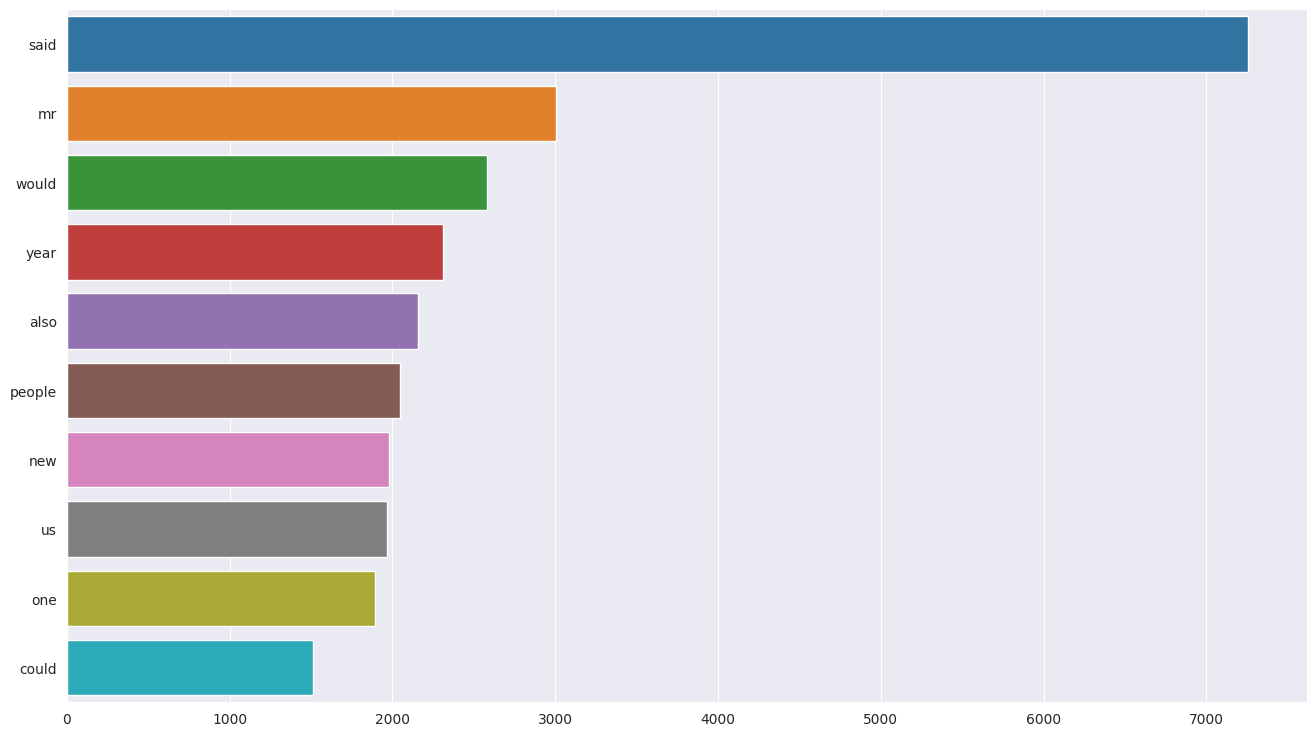

In [88]:
plt.figure(figsize = (16,9))
most_common = get_top_text_ngrams(data.text,10,1)
most_common = dict(most_common)
sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))

In [89]:
category = pd.get_dummies(data.category)
new_cat = pd.concat([data, category], axis=1)
new_cat = new_cat.drop(columns='category')
new_cat.head(10)

,title,content,text,business,entertainment,politics,sport,tech
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly pr...,1,0,0,0,0
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains Greenspan speech dollar hit highe...,1,0,0,0,0
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim owners embat...,1,0,0,0,0
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Airw...,1,0,0,0,0
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares UK dr...,1,0,0,0,0
5,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...,Japan narrowly escapes recession Japan's econo...,1,0,0,0,0
6,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...,Jobs growth still slow US US created fewer job...,1,0,0,0,0
7,India calls for fair trade rules,"India, which attends the G7 meeting of seven ...","India calls fair trade rules India, attends G7...",1,0,0,0,0
8,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...,Ethiopia's crop production 24% Ethiopia produc...,1,0,0,0,0
9,Court rejects $280bn tobacco case,A US government claim accusing the country's ...,Court rejects $280bn tobacco case US governmen...,1,0,0,0,0


In [90]:
news = new_cat['text'].values
label = new_cat[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [91]:
x_train,x_test,y_train,y_test = train_test_split(news, label,test_size = 0.2,shuffle=True)

In [92]:
vocab_size = 10000
max_len = 200
trunc_type = "post"
oov_tok = "<OOV>"

In [93]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
pad_train = pad_sequences(sequences_train, maxlen=max_len, truncating=trunc_type)
pad_test = pad_sequences(sequences_test, maxlen=max_len, truncating=trunc_type)

print(pad_test.shape)

(445, 200)


In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 755973 (2.88 MB)
Trainable params: 755973 (2.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.87 and logs.get('val_accuracy')>0.87):
      self.model.stop_training = True
      print("\n akurasi dari training set and the validation set telah terpenuhi > 87%!")
callbacks = myCallback()

In [96]:
num_epochs = 50
batch_size = 32

history = model.fit(pad_train, y_train, epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(pad_test, y_test),
                    verbose=2,
                    callbacks=[callbacks])


Epoch 1/50
56/56 - 14s - loss: 1.5974 - accuracy: 0.2697 - val_loss: 1.5428 - val_accuracy: 0.3101 - 14s/epoch - 246ms/step
Epoch 2/50
56/56 - 11s - loss: 1.2100 - accuracy: 0.5365 - val_loss: 1.1805 - val_accuracy: 0.5663 - 11s/epoch - 194ms/step
Epoch 3/50
56/56 - 11s - loss: 0.6077 - accuracy: 0.7567 - val_loss: 0.4194 - val_accuracy: 0.8427 - 11s/epoch - 194ms/step
Epoch 4/50
56/56 - 11s - loss: 0.3511 - accuracy: 0.8663 - val_loss: 0.7688 - val_accuracy: 0.7011 - 11s/epoch - 193ms/step
Epoch 5/50

 akurasi dari training set and the validation set telah terpenuhi > 87%!
56/56 - 11s - loss: 0.2613 - accuracy: 0.9298 - val_loss: 0.3471 - val_accuracy: 0.8854 - 11s/epoch - 192ms/step
